# Importance des poids sur les couches du modèle Vgg16

In [8]:
from tensorflow.keras.applications import VGG16

# Charger le modèle pré-entraîné (VGG16)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

# Test Grad-CAM sur images sans background

### Apple___healthy

In [1]:
import pickle
import tensorflow as tf
import cv2
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get('https://drive.google.com/uc?export=download&id=1jTj2GvE2cNbfYiRHEJjGH0Ly-JcuXB1z')
img1 = Image.open(BytesIO(response.content))

# Conversion de l'image en format PNG
img1.save('image.png')

input_shape = (256, 256, 3)

# Chargement du modèle
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Modèles de gradient pour chaque couche
grad_models = [
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_pool').output, model.output])
]

# Grad-CAM Visualization
num_rows = 5
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Grad-CAM Visualization', fontsize=16)

# Affichage de l'image originale
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

for i, grad_model in enumerate(grad_models):
    with tf.GradientTape() as tape:
        img = cv2.imread('image.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (input_shape[1], input_shape[0]))
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.vgg16.preprocess_input(img)

        conv_outputs, predictions = grad_model(img)
        label_idx = tf.argmax(tf.squeeze(predictions)).numpy()  # Index de la classe prédite
        loss = tf.gather(tf.squeeze(predictions), [label_idx])

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (256, 256))
    heatmap = cam / np.max(cam)
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Redimensionner l'image img1 pour correspondre à la taille de l'overlay
    img1_resized = cv2.resize(np.array(img1), (overlay.shape[1], overlay.shape[0]))

    # Convertir les images en uint8
    img1_resized = cv2.cvtColor(img1_resized, cv2.COLOR_RGBA2RGB)
    overlay = np.uint8(overlay)

    # Combinaison de l'image et de l'overlay
    gradcam = cv2.addWeighted(img1_resized, 0.5, overlay, 0.5, 0)
    gradcam = np.uint8(gradcam)

    row = (i + 1) // num_cols
    col = (i + 1) % num_cols

    axs[row, col].imshow(gradcam, cmap='jet')
    axs[row, col].set_title(f'block{i+1}_layer')
    axs[row, col].axis('off')

# Suppression des subplots vides
for i in range(len(grad_models), num_rows * num_cols - 1):
    row = (i + 1) // num_cols
    col = (i + 1) % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Apple___Apple_scab

In [5]:
import pickle
import tensorflow as tf
import cv2
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get('https://drive.google.com/uc?export=download&id=1RpL_WAYm29z06LS08ju7i6jKjadD1CqL')
img1 = Image.open(BytesIO(response.content))

# Conversion de l'image en format PNG
img1.save('image.png')

input_shape = (256, 256, 3)

# Chargement du modèle
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Modèles de gradient pour chaque couche
grad_models = [
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_pool').output, model.output])
]

# Grad-CAM Visualization
num_rows = 5
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Grad-CAM Visualization', fontsize=16)

# Affichage de l'image originale
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

for i, grad_model in enumerate(grad_models):
    with tf.GradientTape() as tape:
        img = cv2.imread('image.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (input_shape[1], input_shape[0]))
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.vgg16.preprocess_input(img)

        conv_outputs, predictions = grad_model(img)
        label_idx = tf.argmax(tf.squeeze(predictions)).numpy()  # Index de la classe prédite
        loss = tf.gather(tf.squeeze(predictions), [label_idx])

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (256, 256))
    heatmap = cam / np.max(cam)
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Redimensionner l'image img1 pour correspondre à la taille de l'overlay
    img1_resized = cv2.resize(np.array(img1), (overlay.shape[1], overlay.shape[0]))

    # Convertir les images en uint8
    img1_resized = cv2.cvtColor(img1_resized, cv2.COLOR_RGBA2RGB)
    overlay = np.uint8(overlay)

    # Combinaison de l'image et de l'overlay
    gradcam = cv2.addWeighted(img1_resized, 0.5, overlay, 0.5, 0)
    gradcam = np.uint8(gradcam)

    row = (i + 1) // num_cols
    col = (i + 1) % num_cols

    axs[row, col].imshow(gradcam, cmap='jet')
    axs[row, col].set_title(f'block{i+1}_layer')
    axs[row, col].axis('off')

# Suppression des subplots vides
for i in range(len(grad_models), num_rows * num_cols - 1):
    row = (i + 1) // num_cols
    col = (i + 1) % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Grape___Black_rot

In [6]:
import pickle
import tensorflow as tf
import cv2
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get('https://drive.google.com/uc?export=download&id=11gQ8mdjAn-Gqxv2lMuoitGTPtmONYZ8P')
img1 = Image.open(BytesIO(response.content))

# Conversion de l'image en format PNG
img1.save('image.png')

input_shape = (256, 256, 3)

# Chargement du modèle
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Modèles de gradient pour chaque couche
grad_models = [
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_pool').output, model.output])
]

# Grad-CAM Visualization
num_rows = 5
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Grad-CAM Visualization', fontsize=16)

# Affichage de l'image originale
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

for i, grad_model in enumerate(grad_models):
    with tf.GradientTape() as tape:
        img = cv2.imread('image.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (input_shape[1], input_shape[0]))
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.vgg16.preprocess_input(img)

        conv_outputs, predictions = grad_model(img)
        label_idx = tf.argmax(tf.squeeze(predictions)).numpy()  # Index de la classe prédite
        loss = tf.gather(tf.squeeze(predictions), [label_idx])

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (256, 256))
    heatmap = cam / np.max(cam)
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Redimensionner l'image img1 pour correspondre à la taille de l'overlay
    img1_resized = cv2.resize(np.array(img1), (overlay.shape[1], overlay.shape[0]))

    # Convertir les images en uint8
    img1_resized = cv2.cvtColor(img1_resized, cv2.COLOR_RGBA2RGB)
    overlay = np.uint8(overlay)

    # Combinaison de l'image et de l'overlay
    gradcam = cv2.addWeighted(img1_resized, 0.5, overlay, 0.5, 0)
    gradcam = np.uint8(gradcam)

    row = (i + 1) // num_cols
    col = (i + 1) % num_cols

    axs[row, col].imshow(gradcam, cmap='jet')
    axs[row, col].set_title(f'block{i+1}_layer')
    axs[row, col].axis('off')

# Suppression des subplots vides
for i in range(len(grad_models), num_rows * num_cols - 1):
    row = (i + 1) // num_cols
    col = (i + 1) % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Tomato___Leaf_Mold

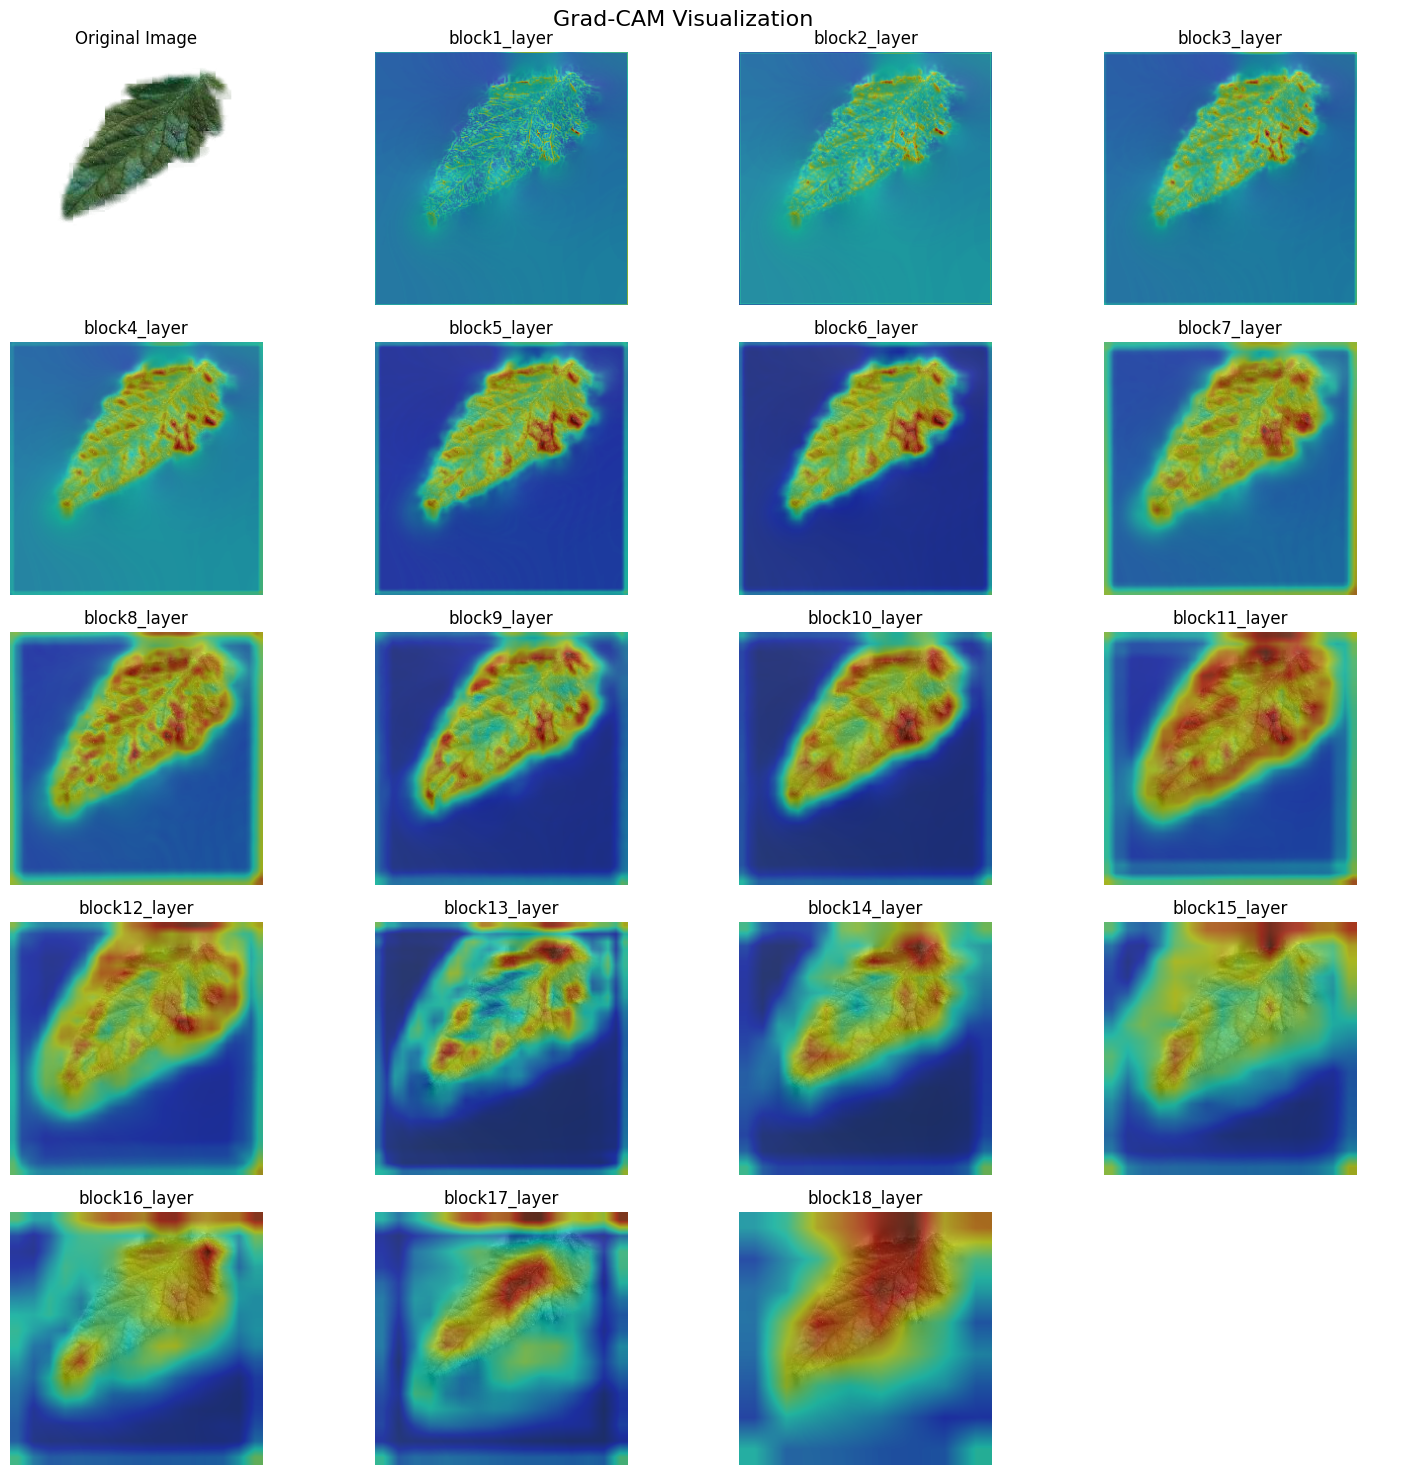

In [7]:
import pickle
import tensorflow as tf
import cv2
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get('https://drive.google.com/uc?export=download&id=1o9krcDSNhE9zWAjIMe5Ab8j-_ngDDBqx')
img1 = Image.open(BytesIO(response.content))

# Conversion de l'image en format PNG
img1.save('image.png')

input_shape = (256, 256, 3)

# Chargement du modèle
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Modèles de gradient pour chaque couche
grad_models = [
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block1_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block2_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block3_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block4_pool').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv1').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv2').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_conv3').output, model.output]),
    tf.keras.models.Model([model.input], [model.get_layer('block5_pool').output, model.output])
]

# Grad-CAM Visualization
num_rows = 5
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Grad-CAM Visualization', fontsize=16)

# Affichage de l'image originale
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

for i, grad_model in enumerate(grad_models):
    with tf.GradientTape() as tape:
        img = cv2.imread('image.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (input_shape[1], input_shape[0]))
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.vgg16.preprocess_input(img)

        conv_outputs, predictions = grad_model(img)
        label_idx = tf.argmax(tf.squeeze(predictions)).numpy()  # Index de la classe prédite
        loss = tf.gather(tf.squeeze(predictions), [label_idx])

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (256, 256))
    heatmap = cam / np.max(cam)
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Redimensionner l'image img1 pour correspondre à la taille de l'overlay
    img1_resized = cv2.resize(np.array(img1), (overlay.shape[1], overlay.shape[0]))

    # Convertir les images en uint8
    img1_resized = cv2.cvtColor(img1_resized, cv2.COLOR_RGBA2RGB)
    overlay = np.uint8(overlay)

    # Combinaison de l'image et de l'overlay
    gradcam = cv2.addWeighted(img1_resized, 0.5, overlay, 0.5, 0)
    gradcam = np.uint8(gradcam)

    row = (i + 1) // num_cols
    col = (i + 1) % num_cols

    axs[row, col].imshow(gradcam, cmap='jet')
    axs[row, col].set_title(f'block{i+1}_layer')
    axs[row, col].axis('off')

# Suppression des subplots vides
for i in range(len(grad_models), num_rows * num_cols - 1):
    row = (i + 1) // num_cols
    col = (i + 1) % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()